# bert 컬럼 추가

## lstm

### 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# %matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error

### 데이터 로드


*   pwd: 현재 경로 표시하기
*   cd drive/MyDrive/bigdata_project/data: 왼쪽 폴더 아이콘 누른 뒤 3번째 아이콘 눌러서 구글 드라이브를 마운트하고 다운 받은 엑셀파일이 저장된 경로를 찾아 들어가야함





In [2]:
/pwd

'/content'

In [8]:
cd drive/MyDrive/bigdata_project/data

/content/drive/MyDrive/bigdata_project/data


In [9]:
ls

datareader_finbert_to_num_v2.xlsx
datareader_finbert_to_num.xlsx
datareader_finbert.xlsx
hyundai_stock_dataset_finBERT_notnull.xlsx
naver_finance_news.xlsx
naver_news.xlsx
preprocessed_dup_eliminated_dataset_finBERT.xlsx
report.xlsx
samsung_stock_dataset_finBERT_notnull_select_column.xlsx
samsung_stock_dataset_finBERT_notnull.xlsx
stock_dataset_finBERT_notnull.xlsx


In [10]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
raw_data = pd.read_excel('samsung_stock_dataset_finBERT_notnull_select_column.xlsx')
raw_data = raw_data.set_index("Date")
print(raw_data.shape)
raw_data = raw_data.dropna(axis=0) # 널값 있는 행 제거
raw_data

(1234, 14)


,Open,High,Low,Close,Volume,Change,MA3,MA10,ATR,PSAR,RSI,OBV,sentiment,Next_day
Date,,,,,,,,,,,,,,
2017-06-21,47740,48120,47480,47480,199473,-0.013710,47393.333333,46084.0,875.714286,45155.552000,69.521025,-103995,-1,47960
2017-06-22,47960,48080,47720,47960,229116,0.010110,47860.000000,46364.0,856.020408,45274.929920,72.281535,125121,-1,47620
2017-06-23,47600,47780,47420,47620,190302,-0.007089,47686.666667,46516.0,833.447522,45389.532723,67.610375,-65181,1,48280
2017-06-26,47520,48360,47520,48280,171056,0.013860,47953.333333,46806.0,833.915556,45499.551414,71.465335,105875,1,48300
2017-06-27,48220,48400,47900,48300,192335,0.000414,48066.666667,47096.0,810.064445,45671.178329,71.575736,298210,1,47700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,67266.666667,67050.0,1181.734320,68543.814928,47.724304,640155380,1,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,66966.666667,66980.0,1140.181869,68482.938629,48.344501,648378263,0,65500
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,66333.333333,66730.0,1158.740307,68423.279857,41.458445,629022508,1,65300


### X, y 설정

             Open   High    Low  Close    Volume    Change           MA3  \
Date                                                                       
2017-06-21  47740  48120  47480  47480    199473 -0.013710  47393.333333   
2017-06-22  47960  48080  47720  47960    229116  0.010110  47860.000000   
2017-06-23  47600  47780  47420  47620    190302 -0.007089  47686.666667   
2017-06-26  47520  48360  47520  48280    171056  0.013860  47953.333333   
2017-06-27  48220  48400  47900  48300    192335  0.000414  48066.666667   
...           ...    ...    ...    ...       ...       ...           ...   
2022-06-02  66600  67000  66400  66700  14959443 -0.010386  67266.666667   
2022-06-03  67200  67300  66800  66800   8222883  0.001499  66966.666667   
2022-06-07  66200  66400  65400  65500  19355755 -0.019461  66333.333333   
2022-06-08  65400  65700  65300  65300  12483180 -0.003053  65866.666667   
2022-06-09  65100  65200  64500  65200  25790725 -0.001531  65333.333333   

           

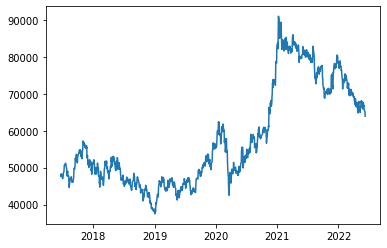

In [11]:
raw_X_A = raw_data.iloc[:, :13] # finbert 결과만 추가했음
raw_y = raw_data.iloc[:, 13:14] # 다음날 종가 데이터가 들어있음

print(raw_X_A)
print(raw_y)

plt.plot(raw_y, label = 'samsung')
plt.show()

### 전처리

In [16]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
# sc_X = sc.fit_transform(raw_X_A)
# sc_y = sc.fit_transform(raw_y)

train_size = int(len(raw_y) * 0.67)
test_size = len(raw_y) - train_size

# 텐서화? 하기
dataX = Variable(torch.Tensor(np.array(raw_X_A)))
dataY = Variable(torch.Tensor(np.array(raw_y)))

# train 데이터 2/3으로 자르기
trainX = Variable(torch.Tensor(np.array(raw_X_A[0:train_size])))
trainY = Variable(torch.Tensor(np.array(raw_y[0:train_size])))

# test 데이터 나머지 1/3으로 자르기
testX = Variable(torch.Tensor(np.array(raw_X_A[train_size:len(raw_X_A)])))
testY = Variable(torch.Tensor(np.array(raw_y[train_size:len(raw_y)])))

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_fin = torch.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_fin = torch.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

dataX_fin = torch.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
print("Training Shape", trainX_fin.shape, trainY.shape)
print("Testing Shape", testX_fin.shape, testY.shape) 
print(dataX_fin.shape, dataY.shape)

torch.Size([818, 13])
torch.Size([403, 13])
torch.Size([818, 1])
torch.Size([403, 1])
Training Shape torch.Size([818, 1, 13]) torch.Size([818, 1])
Testing Shape torch.Size([403, 1, 13]) torch.Size([403, 1])
torch.Size([1221, 1, 13]) torch.Size([1221, 1])


### 모델 정의

In [17]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.relu(h_out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out


### 학습

In [24]:
num_epochs = 5000
learning_rate = 0.001

input_size = trainX_fin.shape[2] # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 2457178624.00000
Epoch: 100, loss: 2456869376.00000
Epoch: 200, loss: 2456236032.00000
Epoch: 300, loss: 2455098624.00000
Epoch: 400, loss: 2453399296.00000
Epoch: 500, loss: 2451209984.00000
Epoch: 600, loss: 2448571648.00000
Epoch: 700, loss: 2445502720.00000
Epoch: 800, loss: 2442023424.00000
Epoch: 900, loss: 2438149632.00000
Epoch: 1000, loss: 2433896448.00000
Epoch: 1100, loss: 2429277952.00000
Epoch: 1200, loss: 2424306944.00000
Epoch: 1300, loss: 2418996736.00000
Epoch: 1400, loss: 2413358336.00000
Epoch: 1500, loss: 2407403520.00000
Epoch: 1600, loss: 2401142784.00000
Epoch: 1700, loss: 2394586112.00000
Epoch: 1800, loss: 2387742208.00000
Epoch: 1900, loss: 2380621568.00000
Epoch: 2000, loss: 2373231360.00000
Epoch: 2100, loss: 2365580288.00000
Epoch: 2200, loss: 2357676288.00000
Epoch: 2300, loss: 2349526016.00000
Epoch: 2400, loss: 2341136384.00000
Epoch: 2500, loss: 2332513536.00000
Epoch: 2600, loss: 2323664896.00000
Epoch: 2700, loss: 2314595840.00000
Epoc

### 모델 평가

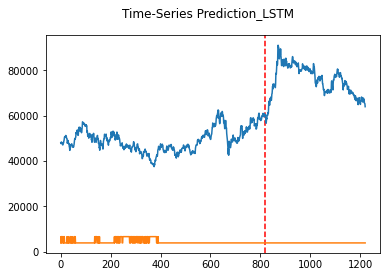

,True,Pred,close,direction,direc_pred
0,47960.0,3802.443604,47480,1,0
1,47620.0,6575.812988,47960,0,0
2,48280.0,3802.443604,47620,1,0
3,48300.0,6575.812988,48280,1,0
4,47700.0,6575.812988,48300,0,0
...,...,...,...,...,...
1216,66800.0,3802.443604,66700,1,0
1217,65500.0,3802.443604,66800,0,0
1218,65300.0,3802.443604,65500,0,0
1219,65200.0,3802.443604,65300,0,0


MSE : 3087306752.0, RMSE : 55563.5390625, SCORE : 47.0%


In [25]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것

# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = lstm(dataX_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin = list(data_predict.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

score_table = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin})


# -----
score_table['close'] = list(raw_data['Close'])

# i[1][0] # True
# i[1][1] # Pred
# i[1][2] # close
# 1: up
# 0: down
# cnt: up&down 맞춘 갯수
# result: up&down 예측 정확도

direction = []
direc_pred = []
for i in score_table.iterrows():
    if i[1][0] >= i[1][2]:
        direction.append(1)
    else:
        direction.append(0)

for i in score_table.iterrows():
    if i[1][1] >= i[1][2]:
        direc_pred.append(1)
    else:
        direc_pred.append(0)

score_table['direction'] = direction
score_table['direc_pred'] = direc_pred

cnt = 0
for i in score_table.iterrows():
    if i[1][3] == i[1][4]:
        cnt += 1

result = cnt/len(score_table)*100
result = result
# -----

display(score_table)

# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

print(f"MSE : {MSE}, RMSE : {RMSE}, SCORE : {result:.1f}%")

## RNN

### 모델 정의

In [20]:
class RNN(nn.Module):
    # Vanilla RNN
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(RNN, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):

        batch_size = x.size(0)

        # initialize hidden state for first input
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # pass model input and hidden state
        h_out, hidden = self.rnn(x, hidden.detach())
        
        h_out = h_out[:,-1,:]
        #h_out = h_out.contiguous().view(-1, self.hidden_size)
        
        out = self.relu(h_out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)

        return out

### 학습

In [21]:
#Vanilla RNN
num_epochs = 10000
learning_rate = 0.001

input_size = trainX_fin.shape[2]
hidden_size = 2
num_layers = 1

num_classes = 1

rnn = RNN(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = rnn(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 2457186560.00000
Epoch: 100, loss: 17443831808.00000
Epoch: 200, loss: 11696851968.00000
Epoch: 300, loss: 7846089216.00000
Epoch: 400, loss: 5265871360.00000
Epoch: 500, loss: 3536994304.00000
Epoch: 600, loss: 2378557440.00000
Epoch: 700, loss: 1602344320.00000
Epoch: 800, loss: 1082241920.00000
Epoch: 900, loss: 733746432.00000
Epoch: 1000, loss: 500236448.00000
Epoch: 1100, loss: 343772416.00000
Epoch: 1200, loss: 238933760.00000
Epoch: 1300, loss: 168686496.00000
Epoch: 1400, loss: 121617032.00000
Epoch: 1500, loss: 90078152.00000
Epoch: 1600, loss: 68945472.00000
Epoch: 1700, loss: 54785496.00000
Epoch: 1800, loss: 45297500.00000
Epoch: 1900, loss: 38940144.00000
Epoch: 2000, loss: 34680348.00000
Epoch: 2100, loss: 31825998.00000
Epoch: 2200, loss: 29913458.00000
Epoch: 2300, loss: 28631972.00000
Epoch: 2400, loss: 27773292.00000
Epoch: 2500, loss: 27197928.00000
Epoch: 2600, loss: 26812388.00000
Epoch: 2700, loss: 26554066.00000
Epoch: 2800, loss: 26380986.00000


### 모델 평가

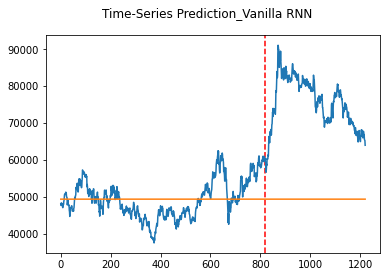

,True,Pred
0,47960.0,49305.640625
1,47620.0,49305.640625
2,48280.0,49305.640625
3,48300.0,49305.640625
4,47700.0,49305.640625
...,...,...
1216,66800.0,49305.640625
1217,65500.0,49305.640625
1218,65300.0,49305.640625
1219,65200.0,49305.640625


MSE : 258502544.0, RMSE : 16083.119140625, SCORE : 51.4%


In [23]:
#Test Vanilla RNN
rnn.eval()
train_predict_rnn = rnn(dataX_fin)
data_predict_rnn = train_predict_rnn.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict_rnn = sc.inverse_transform(data_predict_rnn)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict_rnn)
plt.suptitle('Time-Series Prediction_Vanilla RNN')
plt.show()

# 예측값: data_predict_rnn
# 실제값: dataY_plot

data_predict_fin_rnn = list(data_predict_rnn.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

score_table_rnn = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin_rnn})

display(score_table_rnn)

# -----
score_table_rnn['close'] = list(raw_data['Close'])

# i[1][0] # True
# i[1][1] # Pred
# i[1][2] # close
# 1: up
# 0: down
# cnt: up&down 맞춘 갯수
# result: up&down 예측 정확도

direction = []
direc_pred = []
for i in score_table_rnn.iterrows():
    if i[1][0] >= i[1][2]:
        direction.append(1)
    else:
        direction.append(0)

for i in score_table_rnn.iterrows():
    if i[1][1] >= i[1][2]:
        direc_pred.append(1)
    else:
        direc_pred.append(0)

score_table_rnn['direction'] = direction
score_table_rnn['direc_pred'] = direc_pred

cnt = 0
for i in score_table_rnn.iterrows():
    if i[1][3] == i[1][4]:
        cnt += 1

result_rnn = cnt/len(score_table_rnn)*100
result_rnn = result_rnn
# -----

# validation score
MSE_rnn = mean_squared_error(score_table_rnn['True'], score_table_rnn['Pred'])
RMSE_rnn = np.sqrt(MSE)

print(f"MSE : {MSE_rnn}, RMSE : {RMSE_rnn}, SCORE : {result_rnn:.1f}%")